# SQL Practice: Answering Business Questions Using SQL
## Introduction
In this project, I will be praciticing my SQL skills to answer business questions. For each question, I will:

* Write a SQL query to extract the relevant data
* Create plots where necessary to visualize the data
* Write a short paragraph drawing conclusions, explaining the data and/or visualizations.

## Database
I'll be using the [Chinook database](https://github.com/lerocha/chinook-database), which is a sample database available for SQL Server, Oracle, MySQL, etc. The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers and has the schema below.
<img src= https://s3.amazonaws.com/dq-content/191/chinook-schema.svg>


Now I'll start by setting up the notebook environment and create some helper functions to save time.

In [1]:
#setting up environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
db = 'chinook.db'

#creating a function that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
#creating a function that takes a SQL command as an argument and executes it using the sqlite module
def run_command(c):
    with sqlite.connect(db) as conn:
        conn.isolation_level = None #autocommits any changes
        conn.execute(c)
        
#creating a function that calls the run_query() function to return a list of all tables and views in the databse
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)
#now I'll run the function below to see all the tables and views in chinook.db
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


I see that I have a pandas dataframe of the 11 tables from the chinook database.

## Questions
### 1. Selecting Albums to Purchase
The Chinook record store has just signed a deal with a new record label, and I've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - I have the artist names, and the genre of music they produce:

|Artist Name | Genre |
|------------|-------|
|Regal | Hip-Hop|
|Red Tone | Punk |
|Meteor and the Girls | Pop |
|Slim Jim Bites | Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so I'm interested in finding out which genres sell the best in the USA.

Task: I'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.




In [2]:
q1 = """

WITH usa_tracks AS
    (
     SELECT i.billing_country country,
            il.*
     FROM invoice i
     LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
     WHERE i.billing_country = "USA"
     )

SELECT g.name genres,
       COUNT(ut.invoice_line_id) num_tracks_sold,
       CAST(COUNT(ut.invoice_line_id) as Float)/(SELECT COUNT(*) FROM usa_tracks) percent_sold
FROM usa_tracks ut
LEFT JOIN track t ON t.track_id = ut.track_id
LEFT JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC    
LIMIT 10

"""
usa_tracks_sold = run_query(q1)
usa_tracks_sold

,genres,num_tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Now I'll visualize this data:

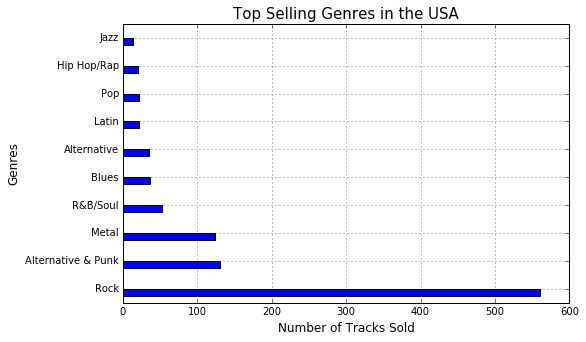

In [3]:
#I set the genre as the dataframe index so it will become the x-axis
usa_tracks_sold.set_index("genres", drop=True, inplace=True)

ax = usa_tracks_sold.plot.barh(figsize = (8,5),legend = False)
ax.set_title("Top Selling Genres in the USA", size=15)
ax.set_xlabel("Number of Tracks Sold", size=12)
ax.set_ylabel("Genres", size=12)
ax.grid()
plt.show()


Based on the results above, we should purchase albums from Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop). However, Rock music dominates the market by making up more than half of purchases. The Chinook record store should consider adding more Rock albums to their inventory.

### 2. Analyzing Employee Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. I have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Task: Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Adding any extra attributes for that employee that I find are relevant to the analysis.

In [12]:
q2 = """
WITH info_table AS
    (SELECT 
        c.customer_id customer_id,
        c.support_rep_id support_agent,
        e.first_name || " " || e.last_name employee_name,
        i.total sales_amount
     FROM employee e
     INNER JOIN customer c on c.support_rep_id = e.employee_id
     INNER JOIN invoice i on i.customer_id = c.customer_id
     )
SELECT employee_name Agent,
       SUM(sales_amount) Total_Sales
FROM info_table
GROUP BY 1
ORDER BY 2 DESC
"""
agent_sales = run_query(q2)
agent_sales

,Agent,Total_Sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


Now that I have my query I can plot the results.

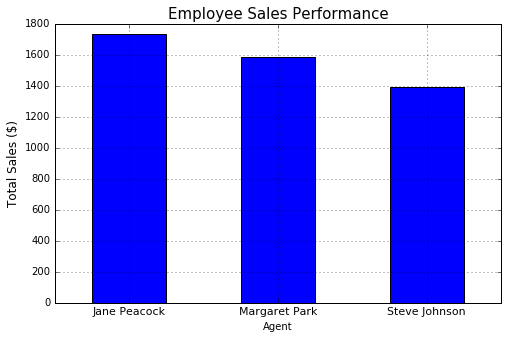

In [28]:
#agent_sales.set_index("Agent", drop=True, inplace=True)

ax = agent_sales.plot.bar(figsize = (8,5),legend = False)
ax.set_title("Employee Sales Performance", size=15)
ax.set_ylabel("Total Sales ($)", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=11)
ax.grid()
plt.show()

Jane Peacock performs the best out of the three sales support agents at Chinook. Since this analysis equates performace with total sales there could be other factors that influence total sales. Perhaps Jane Peacock has been working at Chinook longer, so she's had more time to aquire customers. Maybe she is the head sales support agent and Margaret and Steve report to her. I'll write a query to get more information about each sales support agent to see if there are any factors influencing sales performance.

In [37]:
q = '''
     SELECT 
            c.support_rep_id support_agent,
            e.first_name || " " || e.last_name employee_name,
            e.hire_date hired,
            COUNT(c.customer_id) num_customers,
            e2.first_name || " " || e2.last_name supervisor
     FROM employee e
     INNER JOIN customer c on c.support_rep_id = e.employee_id
     INNER JOIN invoice i on i.customer_id = c.customer_id
     INNER JOIN employee e2 ON e.reports_to = e2.employee_id
     GROUP BY 1
     '''
run_query(q)

,support_agent,employee_name,hired,num_customers,supervisor
0,3,Jane Peacock,2017-04-01 00:00:00,212,Nancy Edwards
1,4,Margaret Park,2017-05-03 00:00:00,214,Nancy Edwards
2,5,Steve Johnson,2017-10-17 00:00:00,188,Nancy Edwards


It appears that Jane Peacock has been working at Chinook the longest, however Margaret Park was hired about a month later. Steve Johnson was hired five months after Margaret. It is interesting to note that although Jane is performing the best and bringing in the most in sales, Margaret actually has 2 more customers than Jane. The difference between Jane and Margaret's sales is about $150. I'll have to assume that Jane's customers may spend more money than Margaret's, or make more frequent purchases.